# **Predicción con T-GCN**

## 0. Import necessary Libraries

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dropout, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import haversine_distances
from sklearn.model_selection import train_test_split
import stellargraph as sg
from stellargraph.layer import GCN_LSTM
from stellargraph.mapper import FullBatchNodeGenerator
import sklearn.metrics as metrics
import osmnx as ox

## 1. Load the data 

In [2]:
#Load the taxi_zones data
shapefile_path = r"C:\Users\Paula\OneDrive\Matematicas y estadistia-UCM\Matematicas y estadistica\TFG\Base de datos\Data (1)\Data\taxi_zones\taxi_zones\taxi_zones.shp"
taxi_zones = gpd.read_file(shapefile_path)

In [3]:
print(taxi_zones.head())

   OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.770 256767.698, 1026495.593 ...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.310 144283.336, 936046.565 14...  


In [4]:
# Load Taxi Zone information 
zone_info_path = r"C:\Users\Paula\OneDrive\Matematicas y estadistia-UCM\Matematicas y estadistica\TFG\Base de datos\Data (1)\Data\taxi_zone_lookup.csv"
zone_info = pd.read_csv(zone_info_path)

In [5]:
print(zone_info.head())

   LocationID        Borough                     Zone service_zone
0           1            EWR           Newark Airport          EWR
1           2         Queens              Jamaica Bay    Boro Zone
2           3          Bronx  Allerton/Pelham Gardens    Boro Zone
3           4      Manhattan            Alphabet City  Yellow Zone
4           5  Staten Island            Arden Heights    Boro Zone


In [6]:
#Taxi demand data 
demand_data_path = r"C:\Users\Paula\OneDrive\Matematicas y estadistia-UCM\Matematicas y estadistica\TFG\Base de datos\Data (1)\taxi_data_cols.csv"
demand_data = pd.read_csv(demand_data_path)

In [7]:
print(demand_data.head())

   PULocationID  DOLocationID      pickup_datetime     dropoff_datetime  \
0          42.0          42.0  2022-01-01 00:14:21  2022-01-01 00:15:33   
1         116.0          41.0  2022-01-01 00:20:55  2022-01-01 00:29:38   
2          41.0         140.0  2022-01-01 00:57:02  2022-01-01 01:13:14   
3         181.0         181.0  2022-01-01 00:07:42  2022-01-01 00:15:57   
4          33.0         170.0  2022-01-01 00:07:50  2022-01-01 00:28:52   

   trip_distance  
0           0.44  
1           2.10  
2           3.70  
3           1.69  
4           6.26  


## 2. Process Data

In [8]:
# Remove the LocationID column from taxi_zones
taxi_zones = taxi_zones.drop(columns=['LocationID'])

In [9]:
# Merge taxi zones and taxi zones information
taxi_zones = taxi_zones.merge(zone_info, left_on="OBJECTID", right_on="LocationID")

print(taxi_zones.head())

   OBJECTID  Shape_Leng  Shape_Area                     zone        borough  \
0         1    0.116357    0.000782           Newark Airport            EWR   
1         2    0.433470    0.004866              Jamaica Bay         Queens   
2         3    0.084341    0.000314  Allerton/Pelham Gardens          Bronx   
3         4    0.043567    0.000112            Alphabet City      Manhattan   
4         5    0.092146    0.000498            Arden Heights  Staten Island   

                                            geometry  LocationID  \
0  POLYGON ((933100.918 192536.086, 933091.011 19...           1   
1  MULTIPOLYGON (((1033269.244 172126.008, 103343...           2   
2  POLYGON ((1026308.770 256767.698, 1026495.593 ...           3   
3  POLYGON ((992073.467 203714.076, 992068.667 20...           4   
4  POLYGON ((935843.310 144283.336, 936046.565 14...           5   

         Borough                     Zone service_zone  
0            EWR           Newark Airport          EWR  
1 

In [10]:
taxi_zones.shape

(263, 10)

### Diferent number of locations 

In [11]:
# Obtain unique locations from each dataset
unique_zones = set(taxi_zones["LocationID"].unique())
unique_zones_df_PU = set(demand_data["PULocationID"].unique())

# Verify sizes
print("Size of unique_zones_csv:", len(unique_zones))
print("Size of unique_zones_df_PU:", len(unique_zones_df_PU))

Size of unique_zones_csv: 263
Size of unique_zones_df_PU: 261


In [12]:
# Identify differences
diff_taxizones_dfPU = unique_zones.symmetric_difference(unique_zones_df_PU)
print("Differences between taxi_zones and the dataset:", diff_taxizones_dfPU)

Differences between taxi_zones and the dataset: {nan, 103, 104, 110}


In [13]:
# ilter rows where OBJECTID is not in {103, 104, 110}
taxi_zones_filtered = taxi_zones[~taxi_zones['OBJECTID'].isin([103, 104, 110])]
unique_zones_filtered = set(taxi_zones_filtered["LocationID"].unique())

print(len(unique_zones_filtered))

260


## 3. Create graphs and adjecent matrix

In [14]:
# Extract the centroid coordinates of each zone
taxi_zones_filtered['centroid'] = taxi_zones_filtered.centroid
taxi_zones_filtered['centroid_x'] = taxi_zones_filtered.centroid.x
taxi_zones_filtered['centroid_y'] = taxi_zones_filtered.centroid.y

# Create a DataFrame with coordinates
coords = taxi_zones_filtered[['LocationID', 'centroid_x', 'centroid_y']]

print(coords.head())

C:\Users\Paula\myenv\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Paula\myenv\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


   LocationID    centroid_x     centroid_y
0           1  9.359968e+05  191376.749531
1           2  1.031086e+06  164018.754403
2           3  1.026453e+06  254265.478659
3           4  9.906340e+05  202959.782391
4           5  9.318714e+05  140681.351376


C:\Users\Paula\myenv\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [15]:
# Convert coordinates to latitude and longitude
coords_gdf = gpd.GeoDataFrame(coords, geometry=gpd.points_from_xy(coords.centroid_x, coords.centroid_y))
coords_gdf.set_crs(epsg=2263, inplace=True)
coords_gdf = coords_gdf.to_crs(epsg=4326)

#  Extract coordinates in radians
coords_gdf['centroid_lat'] = np.radians(coords_gdf.geometry.y)
coords_gdf['centroid_lon'] = np.radians(coords_gdf.geometry.x)

print(coords_gdf.head())

   LocationID    centroid_x     centroid_y                    geometry  \
0           1  9.359968e+05  191376.749531  POINT (-74.17400 40.69183)   
1           2  1.031086e+06  164018.754403  POINT (-73.83130 40.61675)   
2           3  1.026453e+06  254265.478659  POINT (-73.84742 40.86447)   
3           4  9.906340e+05  202959.782391  POINT (-73.97697 40.72375)   
4           5  9.318714e+05  140681.351376  POINT (-74.18848 40.55266)   

   centroid_lat  centroid_lon  
0      0.710206     -1.294581  
1      0.708896     -1.288599  
2      0.713220     -1.288881  
3      0.710764     -1.291142  
4      0.707777     -1.294833  


In [16]:
# Create the taxi zones graph
G = nx.Graph()
for _, row in coords.iterrows():
    G.add_node(row['LocationID'], pos=(row['centroid_x'], row['centroid_y']), features=[row['centroid_x'], row['centroid_y']])

# Calculate distances and add edges
coords_rad = coords_gdf[['centroid_lat', 'centroid_lon']].to_numpy()
distances = haversine_distances(coords_rad) * 6371000 / 1609.34  # convert to miles
threshold_distance = 15  # threshold in miles

for i, zone1 in enumerate(coords['LocationID']):
    for j, zone2 in enumerate(coords['LocationID']):
        if i != j and distances[i, j] < threshold_distance:
            G.add_edge(zone1, zone2, weight=distances[i, j])

In [17]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"Número de nodos: {num_nodes}")
print(f"Número de aristas: {num_edges}")

Número de nodos: 260
Número de aristas: 28877


In [18]:
# Create StellarGraph object with node features
node_features = pd.DataFrame.from_dict({node: data['features'] for node, data in G.nodes(data=True)}, orient='index')
stellar_graph = sg.StellarGraph.from_networkx(G, node_features=node_features)

In [19]:
# Get the adjacency matrix
adj_matrix = stellar_graph.to_adjacency_matrix()
print(adj_matrix.shape)

(260, 260)


### Verification

In [20]:
for threshold in [1, 5, 10, 20]:
    G_test = nx.Graph()
    for i, zone1 in enumerate(coords['LocationID']):
        for j, zone2 in enumerate(coords['LocationID']):
            if i != j and distances[i, j] < threshold:
                G_test.add_edge(zone1, zone2, weight=distances[i, j])
    print(f"Umbral: {threshold}, Número de aristas: {G_test.number_of_edges()}")

Umbral: 1, Número de aristas: 405
Umbral: 5, Número de aristas: 7370
Umbral: 10, Número de aristas: 19587
Umbral: 20, Número de aristas: 32127


In [21]:
# Convertir la matriz de distancias a un DataFrame para una inspección más fácil
distances_df = pd.DataFrame(distances, index=coords['LocationID'], columns=coords['LocationID'])
print(distances_df.head())

LocationID        1          2          3          4          5          6    \
LocationID                                                                     
1            0.000000  18.697857  20.838670  10.552881   9.645788   8.288357   
2           18.697857   0.000000  17.137156  10.627224  19.258412  12.664565   
3           20.838670  17.137156   0.000000  11.851341  27.986698  21.704144   
4           10.552881  10.627224  11.851341   0.000000  16.209041   9.869963   
5            9.645788  19.258412  27.986698  16.209041   0.000000   6.954341   

LocationID        7          8          9          10   ...        254  \
LocationID                                              ...              
1           14.159031  14.438729  20.625464  20.087237  ...  21.084884   
2           11.021222  12.170240   9.552410   4.789548  ...  18.395154   
3            8.056763   7.133716   8.432489  13.154020  ...   1.362135   
4            3.973535   4.721619  10.073626  10.221832  ...  12.56532

### Visualization

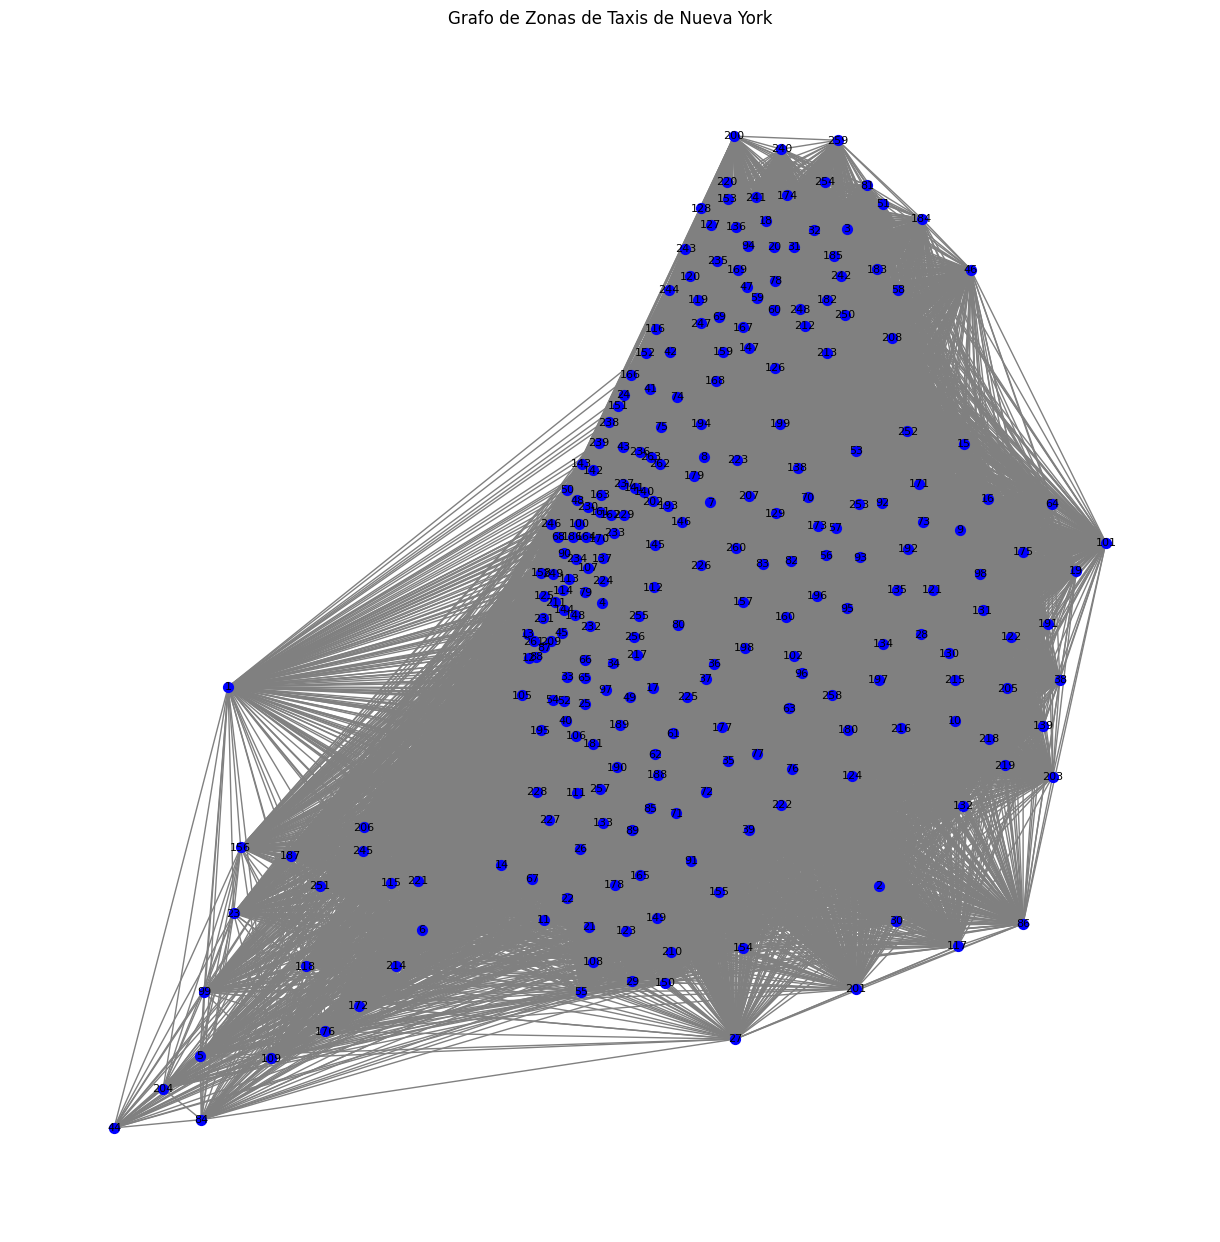

In [22]:
# Extraer posiciones de los nodos
pos = {zone: (data['pos'][0], data['pos'][1]) for zone, data in G.nodes(data=True)}

# Dibujar el grafo
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_size=50, node_color='blue', font_size=8, font_color='black', edge_color='gray')
plt.title('Grafo de Zonas de Taxis de Nueva York')
plt.show()


### Example
Alphabet City, 
Chinatown, SoHoand  TriBeCa/Civic Center

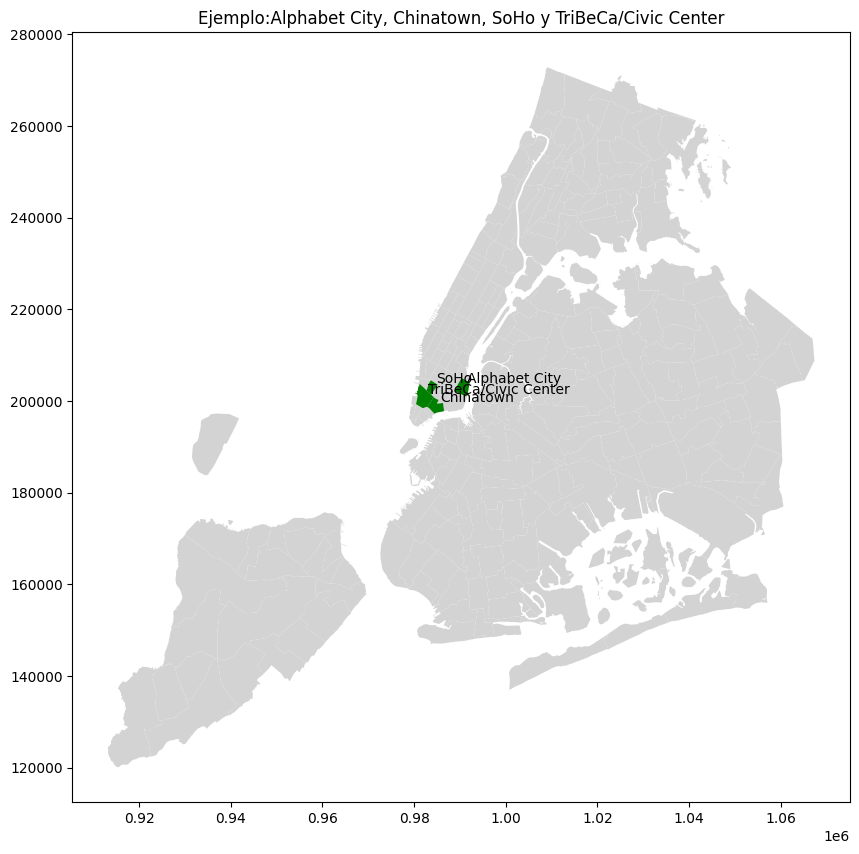

In [23]:
# Define the LocationIDs 
location_ids = [4, 45, 211, 231]

# Filter the GeoDataFrame to highlight the specific zones
highlighted_zones = taxi_zones_filtered[taxi_zones_filtered['OBJECTID'].isin(location_ids)]

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot all zones in light grey
taxi_zones_filtered.plot(ax=ax, color='lightgrey')

# Highlight specific zones in red
highlighted_zones.plot(ax=ax, color='green')

# Add title
ax.set_title("Ejemplo:Alphabet City, Chinatown, SoHo y TriBeCa/Civic Center")

# Add annotations for the highlighted zones
for x, y, label in zip(highlighted_zones.geometry.centroid.x, highlighted_zones.geometry.centroid.y, highlighted_zones['zone']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=10, color='black')

# Show the plot
plt.show()


In [24]:
# Definir los LocationIDs que quieres extraer
location_ids = [4, 45, 211, 231]

# Filtrar el DataFrame para obtener solo los LocationIDs específicos
filtered_df = coords_gdf[coords_gdf['LocationID'].isin(location_ids)]

# Mostrar el DataFrame filtrado
print(filtered_df)

     LocationID     centroid_x     centroid_y                    geometry  \
3             4  990633.980641  202959.782391  POINT (-73.97697 40.72375)   
44           45  984762.469283  198844.636117  POINT (-73.99815 40.71246)   
210         211  983823.807116  203008.491333  POINT (-74.00154 40.72389)   
230         231  982065.701385  200780.540427  POINT (-74.00788 40.71777)   

     centroid_lat  centroid_lon  
3        0.710764     -1.291142  
44       0.710566     -1.291511  
210      0.710766     -1.291570  
230      0.710659     -1.291681  


In [25]:
# Definir los LocationIDs que quieres extraer
location_ids = [4, 45, 211, 231]

# Filtrar el DataFrame para obtener solo las filas y columnas con los LocationIDs específicos
filtered_distances_df = distances_df.loc[distances_df.index.isin(location_ids), distances_df.columns.isin(location_ids)]

# Mostrar el DataFrame filtrado
print(filtered_distances_df)

LocationID       4         45        211       231
LocationID                                        
4           0.000000  1.356242  1.286568  1.670592
45          1.356242  0.000000  0.809320  0.627960
211         1.286568  0.809320  0.000000  0.537432
231         1.670592  0.627960  0.537432  0.000000


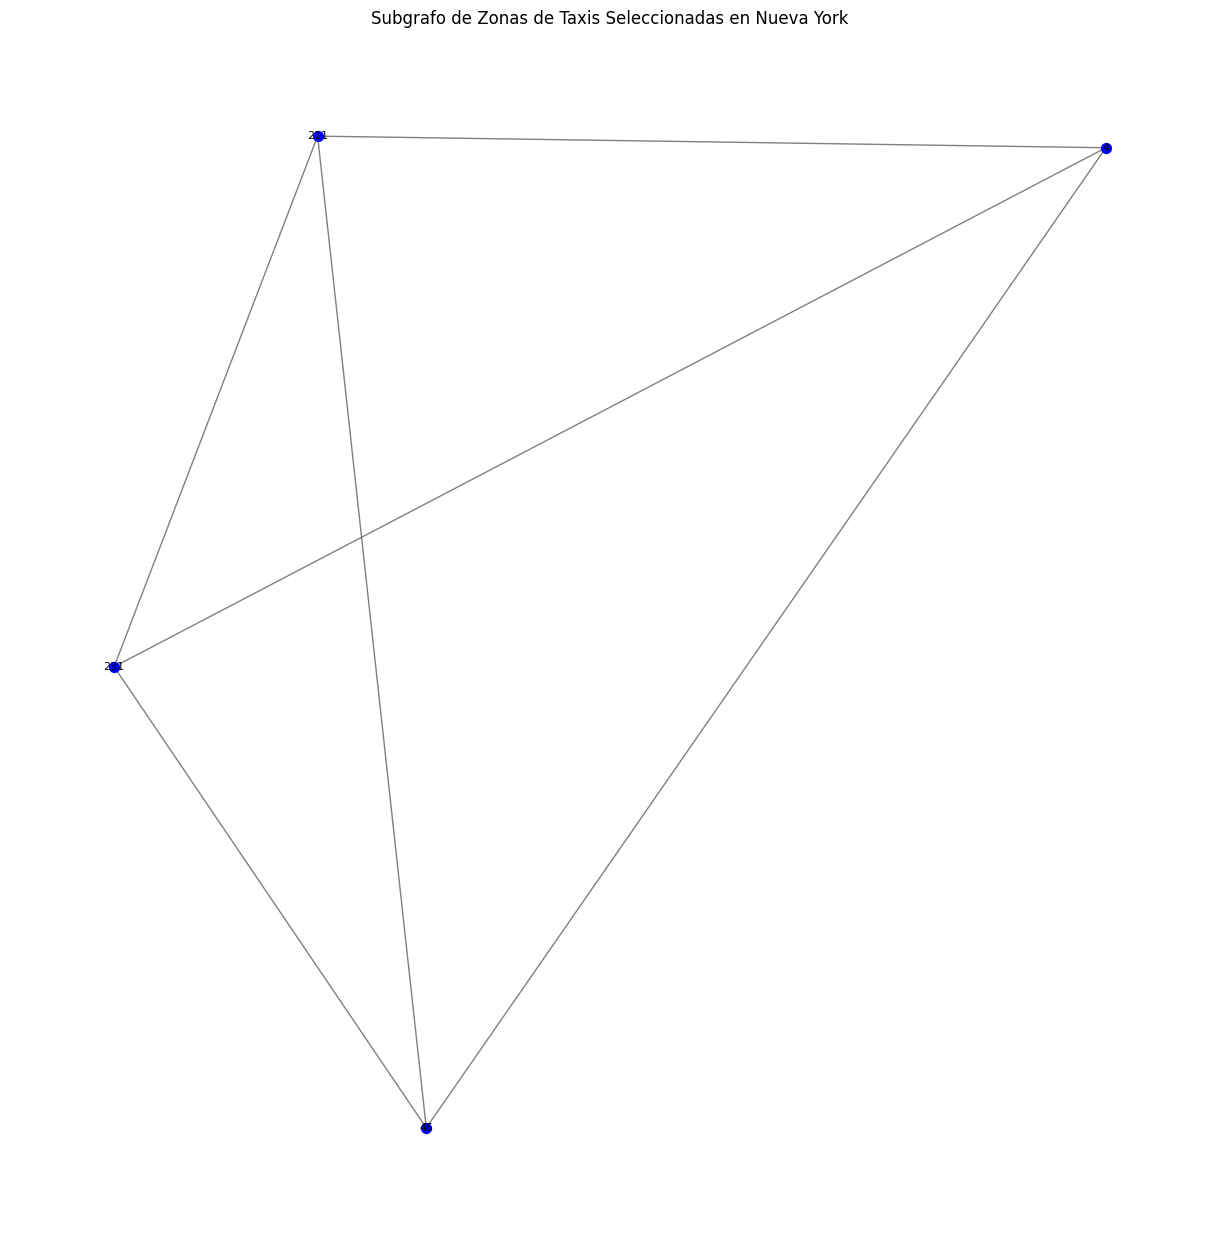

In [26]:
# Select 4 specifict LocationIDs
sub_zone_ids = [4, 45, 211, 231] 

# Create subgraph
sub_G = G.subgraph(sub_zone_ids)

# Extract the positions of the subgraph
sub_pos = {zone: (data['pos'][0], data['pos'][1]) for zone, data in sub_G.nodes(data=True)}

# plot the subgraph
plt.figure(figsize=(12, 12))
nx.draw(sub_G, sub_pos, with_labels=True, node_size=50, node_color='blue', font_size=8, font_color='black', edge_color='gray')
plt.title('Subgrafo de Zonas de Taxis Seleccionadas en Nueva York')
plt.show()


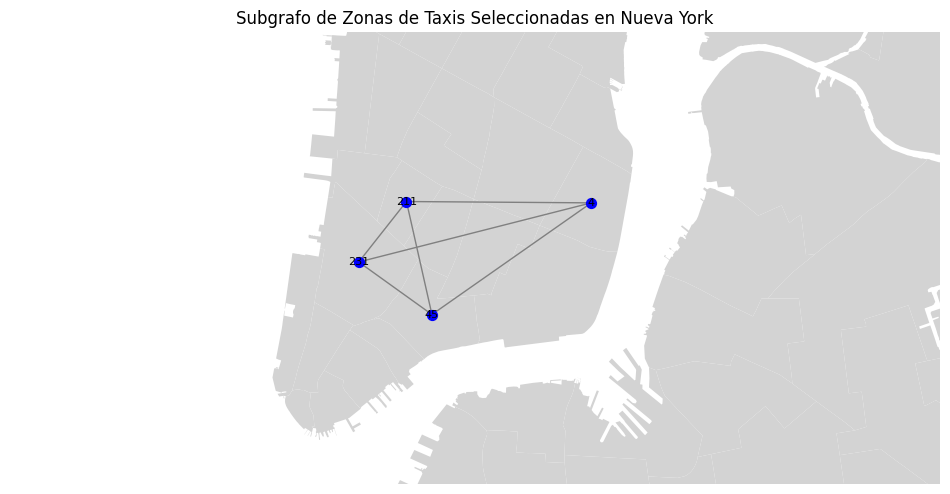

In [27]:
# Select 4 specifict LocationIDs
sub_zone_ids = [4, 45, 211, 231] 

# Create subgraph
sub_G = G.subgraph(sub_zone_ids)

# Extract the positions of the subgraph
sub_pos = {zone: (data['pos'][0], data['pos'][1]) for zone, data in sub_G.nodes(data=True)}

# Calcular los límites del zoom
x_vals = [pos[0] for pos in sub_pos.values()]
y_vals = [pos[1] for pos in sub_pos.values()]
x_min, x_max = min(x_vals), max(x_vals)
y_min, y_max = min(y_vals), max(y_vals)

# Agregar un margen alrededor de los límites
x_margin = (x_max - x_min) * 1.5
y_margin = (y_max - y_min) * 1.5

# Plotear el mapa de Nueva York
fig, ax = plt.subplots(figsize=(12, 12))
taxi_zones_filtered.plot(ax=ax, color='lightgrey')

# Plotear el subgrafo sobre el mapa
nx.draw(sub_G, sub_pos, with_labels=True, node_size=50, node_color='blue', font_size=8, font_color='black', edge_color='gray', ax=ax)

# Ajustar los límites del eje para hacer zoom
ax.set_xlim(x_min - x_margin, x_max + x_margin)
ax.set_ylim(y_min - y_margin, y_max + y_margin)

# Añadir título
plt.title('Subgrafo de Zonas de Taxis Seleccionadas en Nueva York')
plt.show()

## 4. Prepare the data 

In [28]:
# Convert pickup_datetime to datetime
demand_data['pickup_datetime'] = pd.to_datetime(demand_data['pickup_datetime'])

# Extract the hour from pickup_datetime
demand_data['hour'] = demand_data['pickup_datetime'].dt.hour

# Group by LocationID and hour
demand_aggregated = demand_data.groupby(['PULocationID', 'hour']).size().reset_index(name='demand')

# Pivot the data to create a time series for each location
demand_pivot = demand_aggregated.pivot_table(index='hour', columns='PULocationID', values='demand', fill_value=0)

# Verify the pivot table
print(demand_pivot.head())


PULocationID  1.0    2.0    3.0    4.0    5.0    6.0    7.0    8.0    9.0    \
hour                                                                          
0.0               0      0      0    529      0      1    220      0      0   
1.0               2      0      0    538      1      0    152      1      0   
2.0               2      0      0    464      0      0    109      0      1   
3.0               0      0      0    262      0      0     75      0      0   
4.0               1      0      4     87      0      0     67      0      2   

PULocationID  10.0   ...  254.0  255.0  256.0  257.0  258.0  259.0  260.0  \
hour                 ...                                                    
0.0              40  ...      2    388    242      4      8      0     94   
1.0              17  ...      2    294    228      4      6      2     63   
2.0               3  ...      0    228    209      3      1      1     36   
3.0              12  ...      2     94    103      4      2  

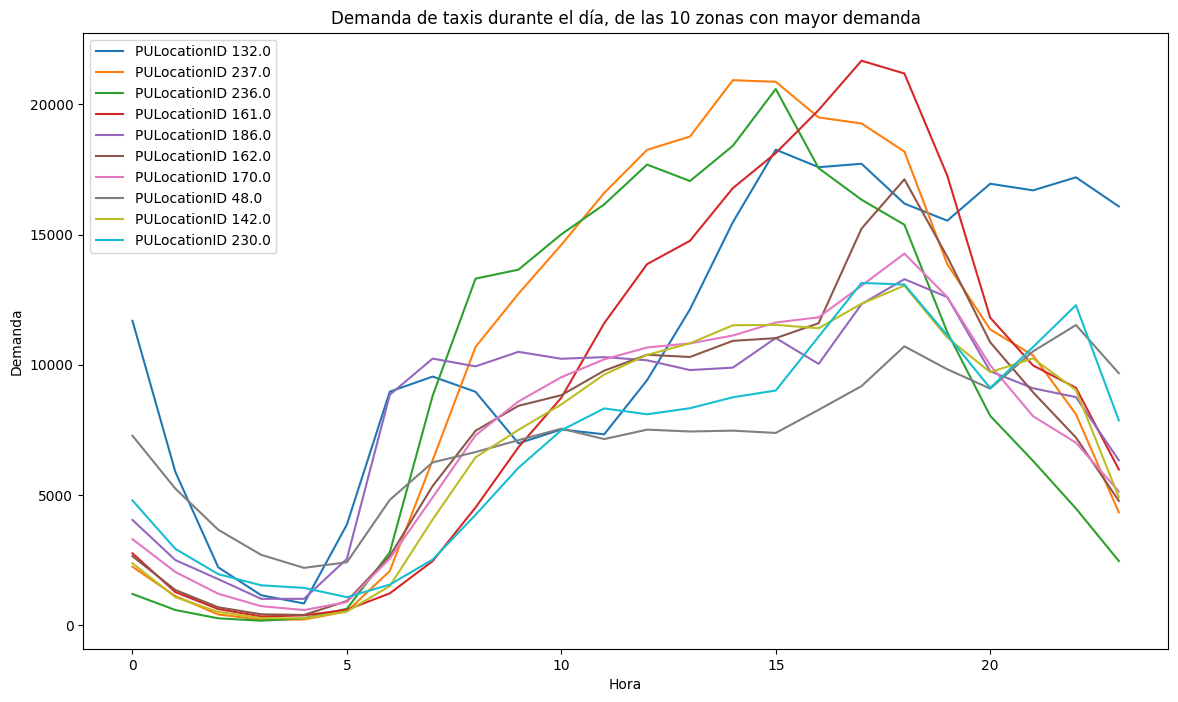

In [29]:
# Calcular la demanda total por ubicación
total_demand = demand_pivot.sum(axis=0)

# Seleccionar las 10 ubicaciones con mayor demanda
top_10_locations = total_demand.nlargest(10).index

# Crear la gráfica
plt.figure(figsize=(14, 8))

for location in top_10_locations:
    plt.plot(demand_pivot.index, demand_pivot[location], label=f'PULocationID {location}')

plt.title('Demanda de taxis durante el día, de las 10 zonas con mayor demanda')
plt.xlabel('Hora')
plt.ylabel('Demanda')
plt.legend()
plt.show()

In [30]:
# Normalize the data
scaler = MinMaxScaler()
demand_per_zone_normalized = pd.DataFrame(scaler.fit_transform(demand_pivot), columns=demand_pivot.columns, index=demand_pivot.index)

C:\Users\Paula\myenv\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\Paula\myenv\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


In [31]:
# Convert normalized data to numpy array
demand_data_normalized = demand_per_zone_normalized.values
print("Datos normalizados shape:", demand_data_normalized.shape)

Datos normalizados shape: (24, 260)


## 5. Create Time Sequences

In [32]:
n_nodes = adj_matrix.shape[0]
print("Number of nodes:", n_nodes)

Number of nodes: 260


In [33]:
# Prepare sequences of data for T-GCN
sequence_length = 12  # Number of previous time steps to use for prediction

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(demand_data_normalized, sequence_length)

print("X shape: ", X.shape)
print("Y shape: ", y.shape)

X shape:  (12, 12, 260)
Y shape:  (12, 260)


## 6. Split into training and testing sets

In [34]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X Train data shape:", X_train.shape)
print("X Test data shape:", X_test.shape)
print("y Train data shape:", y_train.shape)
print("y Test data shape:", y_test.shape)

X Train data shape: (9, 12, 260)
X Test data shape: (3, 12, 260)
y Train data shape: (9, 260)
y Test data shape: (3, 260)


In [35]:
# Convert to tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)


print("Train X shape: ", X_train.shape)
print("Train Y shape: ", X_test.shape)
print("Test X shape: ", y_train.shape)
print("Test Y shape: ", y_test.shape)

Train X shape:  (9, 12, 260)
Train Y shape:  (3, 12, 260)
Test X shape:  (9, 260)
Test Y shape:  (3, 260)


In [36]:
# Adjust the data shape for T-GCN
num_nodes = 260

def adjust_data_shape(data, num_nodes, sequence_length):
    """
    Reorganize the data to have shape (batch_size, num_nodes, sequence_length)
    """
    batch_size, seq_len, num_nodes = data.shape
    if num_nodes != 260:  # Verifica que los datos tienen el tamaño correcto para los nodos
        raise ValueError("Número de nodos en los datos no coincide con el número esperado.")
    
    # Create a new structure for the data
    new_data = np.zeros((batch_size, num_nodes, sequence_length))
    
    # We assume that the input data has this shape: (batch_size, sequence_length, num_nodes)
    for i in range(batch_size):
        for j in range(sequence_length):
            if j < num_nodes:
                new_data[i, j, :] = data[i, :, j]
    
    return new_data

# Adjust training and testing data
X_train_reshaped = adjust_data_shape(X_train, num_nodes, sequence_length)
X_test_reshaped = adjust_data_shape(X_test, num_nodes, sequence_length)

# Verify new shape
print(X_train_reshaped.shape)  
print(X_test_reshaped.shape)   

(9, 260, 12)
(3, 260, 12)


## 7. Create and train the T-GCN Model

In [37]:
generator = FullBatchNodeGenerator(stellar_graph, method="gcn")

Using GCN (local pooling) filters...


In [38]:
gcn_lstm = GCN_LSTM(
    seq_len=sequence_length,
    adj=adj_matrix.todense(),
    gc_layer_sizes=[16, 10],
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[200, 200],
    lstm_activations=["tanh", "tanh"],
)

C:\Users\Paula\myenv\lib\site-packages\ipykernel_launcher.py:7: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  import sys


In [39]:
x_input, x_output = gcn_lstm.in_out_tensors()
x_output = Dropout(0.5)(x_output)
x_output = Dense(X_train_reshaped.shape[1])(x_output) 

In [40]:
model = Model(inputs=x_input, outputs=x_output)
model.compile(optimizer="adam", loss="mae", metrics=["mse"])

In [41]:
# Fit the model
history = model.fit(
    X_train_reshaped, 
    y_train,
    epochs=500,
    batch_size=64,
    shuffle=True,
    verbose=1,
    validation_split=0.2,
    validation_data=(X_test_reshaped, y_test)
)

Epoch 1/500
1/1 [==============================] - 22s 22s/step - loss: 0.7365 - mse: 0.8294 - val_loss: 0.4952 - val_mse: 0.3936
Epoch 2/500
1/1 [==============================] - 0s 128ms/step - loss: 0.6711 - mse: 0.7124 - val_loss: 0.4188 - val_mse: 0.2966
Epoch 3/500
1/1 [==============================] - 0s 124ms/step - loss: 0.6204 - mse: 0.6011 - val_loss: 0.3546 - val_mse: 0.2222
Epoch 4/500
1/1 [==============================] - 0s 175ms/step - loss: 0.5644 - mse: 0.5166 - val_loss: 0.3040 - val_mse: 0.1668
Epoch 5/500
1/1 [==============================] - 0s 141ms/step - loss: 0.5165 - mse: 0.4267 - val_loss: 0.2682 - val_mse: 0.1281
Epoch 6/500
1/1 [==============================] - 0s 209ms/step - loss: 0.4865 - mse: 0.3702 - val_loss: 0.2462 - val_mse: 0.1041
Epoch 7/500
1/1 [==============================] - 0s 235ms/step - loss: 0.4487 - mse: 0.3247 - val_loss: 0.2350 - val_mse: 0.0918
Epoch 8/500
1/1 [==============================] - 0s 204ms/step - loss: 0.4324 - ms

In [42]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 260, 12)]         0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 260, 12, 1)       0         
                                                                 
 reshape (Reshape)           (None, 260, 12)           0         
                                                                 
 fixed_adjacency_graph_convo  (None, 260, 16)          68052     
 lution (FixedAdjacencyGraph                                     
 Convolution)                                                    
                                                                 
 fixed_adjacency_graph_convo  (None, 260, 10)          68020     
 lution_1 (FixedAdjacencyGra                                     
 phConvolution)                                              

1. **Input Layer**: input_1 (InputLayer)
2. **Graph Convolutional Layers (GCN)**: tf.expand_dims (TFOpLambda), reshape (Reshape), fixed_adjacency_graph_convolution FixedAdjacencyGraphConvolution), fixed_adjacency_graph_convolution_1 (FixedAdjacencyGraphConvolution). 
   These layers capture spatial dependencies between nodes using a fixed adjacency matrix. They effectively learn the spatial relationships in the data.
3. **Reshape and Permute Layers**: reshape_1 (Reshape),permute (Permute), reshape_2 (Reshape).
   Reshape and Permute operations to ensure the data is in the correct format for the LSTM layers.
4. **Long Short-Term Memory Layers (LSTM)**: lstm (LSTM), lstm_1 (LSTM)
   These layers capture temporal dependencies in the sequence data. They learn how the data evolves over time.
5. **Dropout Layers**: dropout (Dropout), dense (Dense), dropout_1 (Dropout). 
   These layers help prevent overfitting by randomly setting a fraction of input units to zero during training.
6. **Dense Layers**: dense_1 (Dense). 
   These layers map the learned features to the output shape, corresponding to the number of nodes.

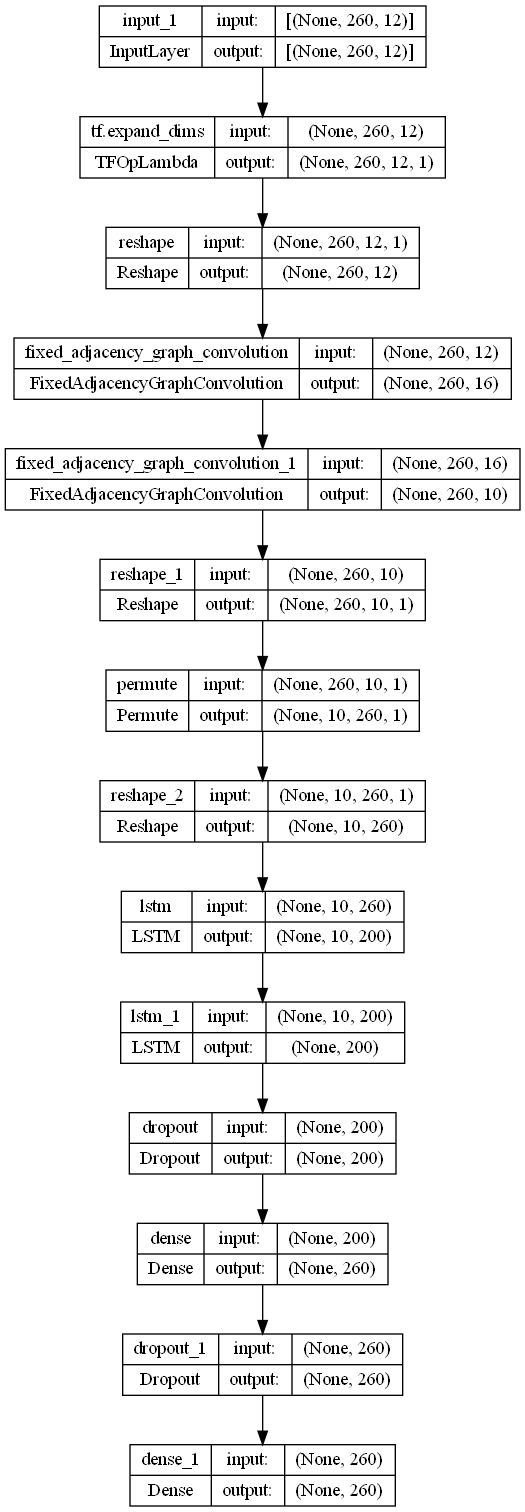

In [43]:
from keras.utils.vis_utils import plot_model

# Suponiendo que ya tienes tu modelo definido como `model`
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


## 8. Model evaluation

<AxesSubplot:title={'center':'Función de coste MAE'}>

<Figure size 640x480 with 0 Axes>

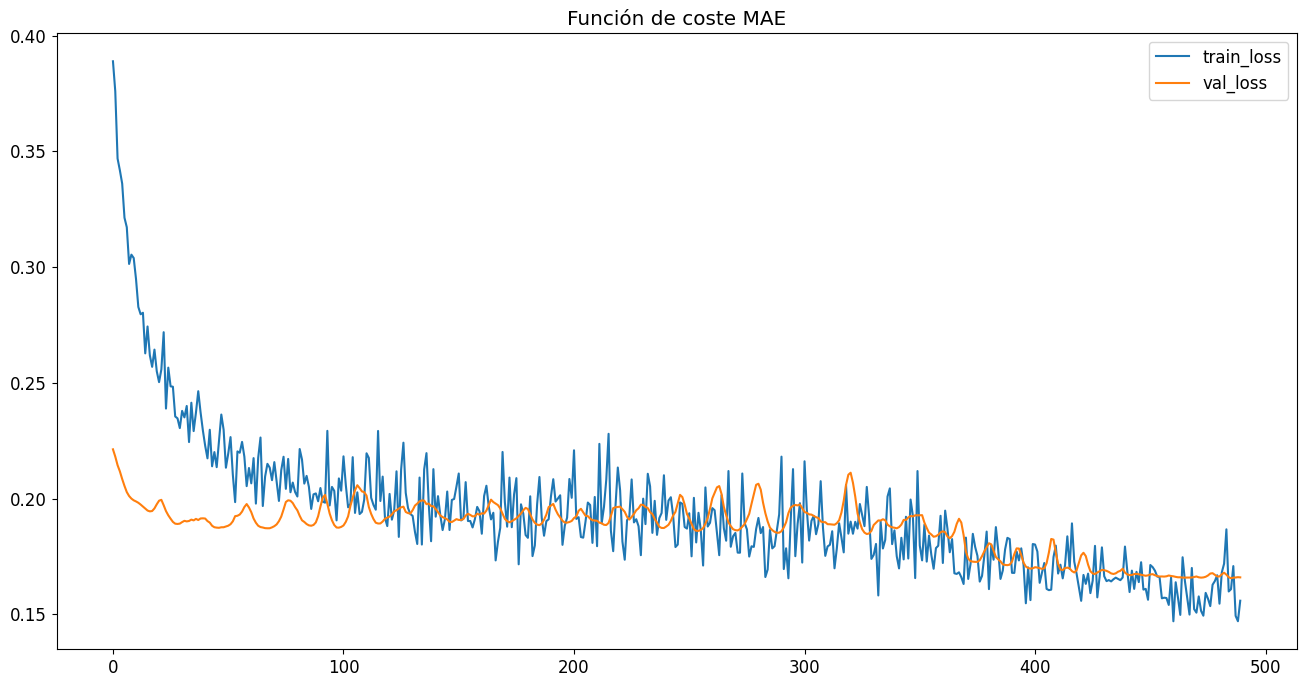

In [44]:
plt.figure()
plt.rcParams.update({'font.size': 12}) # must set in top
pd.DataFrame({'train_loss':history.history["loss"][10:],
              'val_loss':history.history["val_loss"][10:]})\
    .plot(figsize=[16,8], title='Función de coste MAE',
         fontsize=12)

<AxesSubplot:title={'center':'Función de coste MSE'}>

<Figure size 640x480 with 0 Axes>

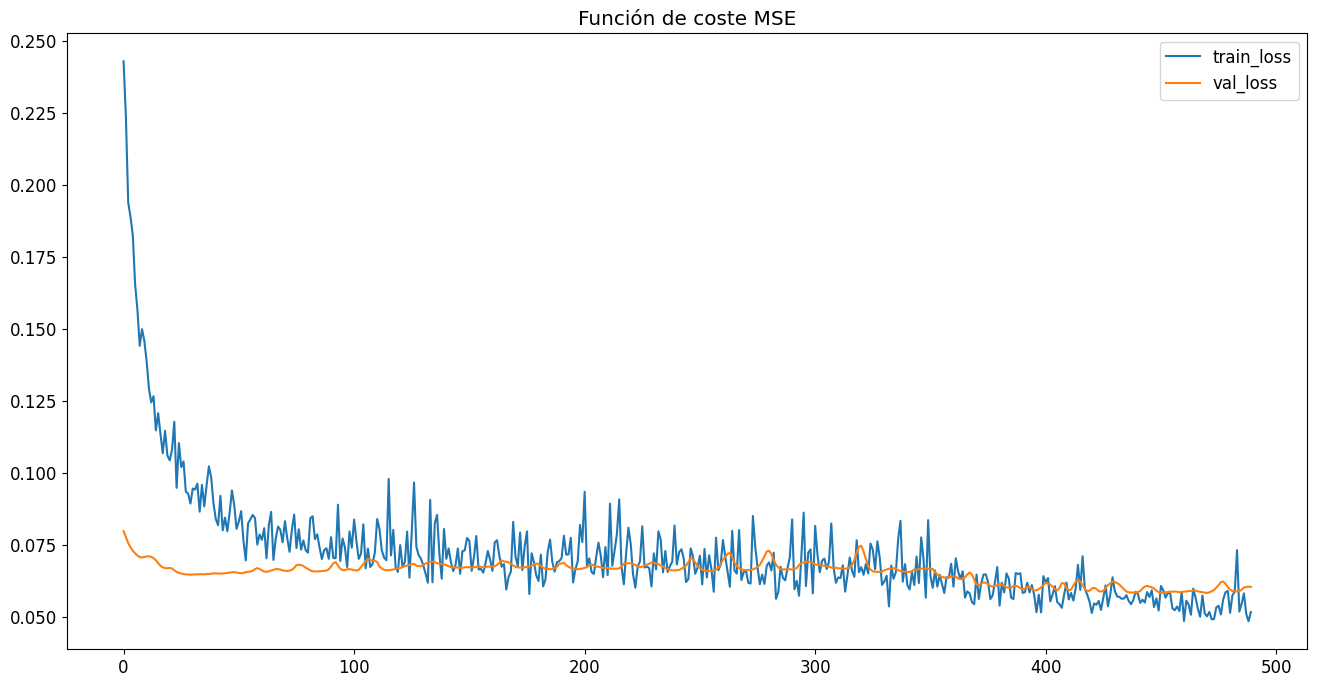

In [45]:
plt.figure()
plt.rcParams.update({'font.size': 12}) # must set in top
pd.DataFrame({'train_loss':history.history["mse"][10:],
              'val_loss':history.history["val_mse"][10:]})\
    .plot(figsize=[16,8], title='Función de coste MSE',
         fontsize=12)

In [46]:
# Make predictions on the training and test sets
yhat_train = model.predict(X_train_reshaped)
yhat_test = model.predict(X_test_reshaped)

1/1 [==============================] - 0s 94ms/step


In [47]:
# Invert normalization for predictions and true values
y_train_inverse = scaler.inverse_transform(y_train.numpy())
yhat_train_inverse = scaler.inverse_transform(yhat_train)
y_test_inverse = scaler.inverse_transform(y_test.numpy())
yhat_test_inverse = scaler.inverse_transform(yhat_test)

# Calculate metrics for the training set
mae_train = metrics.mean_absolute_error(y_train_inverse, yhat_train_inverse)
mse_train = metrics.mean_squared_error(y_train_inverse, yhat_train_inverse)
mape_train = metrics.mean_absolute_percentage_error(y_train_inverse, yhat_train_inverse)
rmse_train = np.sqrt(mse_train)
r2_train = metrics.r2_score(y_train_inverse, yhat_train_inverse)

print("Resultados en el conjunto de entrenamiento:")
print("MAE:", mae_train)
print("MSE:", mse_train)
print("RMSE:", rmse_train)
print("MAPE:", mape_train)
print("R-Squared:", r2_train)

Resultados en el conjunto de entrenamiento:
MAE: 210.74065
MSE: 477937.28
RMSE: 691.3301
MAPE: 221269620000000.0
R-Squared: -0.027089195961473852


In [48]:
# Calculate metrics for the test set
mae_test = metrics.mean_absolute_error(y_test_inverse, yhat_test_inverse)
mse_test = metrics.mean_squared_error(y_test_inverse, yhat_test_inverse)
mape_test = metrics.mean_absolute_percentage_error(y_test_inverse, yhat_test_inverse)
rmse_test = np.sqrt(mse_test)
r2_test = metrics.r2_score(y_test_inverse, yhat_test_inverse)

print("Resultados en el conjunto de prueba:")
print("MAE:", mae_test)
print("MSE:", mse_test)
print("RMSE:", rmse_test)
print("MAPE:", mape_test)
print("R-Squared:", r2_test)


Resultados en el conjunto de prueba:
MAE: 260.384
MSE: 763852.0
RMSE: 873.98627
MAPE: 362887600000000.0
R-Squared: -15.200075441310135


In [49]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"Test Loss: {test_loss}")

Test Loss: [0.1659393310546875, 0.06047656014561653]


In [50]:
# Make predictions on the test set
y_pred = model.predict(X_test_reshaped)

# Invert normalization for predictions and true values
y_test_inverse = scaler.inverse_transform(y_test.numpy())
y_pred_inverse = scaler.inverse_transform(y_pred)

# Calculate MAE and MSE
mae = metrics.mean_absolute_error(y_test_inverse, y_pred_inverse)
rmse = np.sqrt(metrics.mean_squared_error(y_test_inverse, y_pred_inverse))

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

1/1 [==============================] - 0s 94ms/step
Mean Absolute Error: 260.3840026855469
Root Mean Squared Error: 873.9862670898438


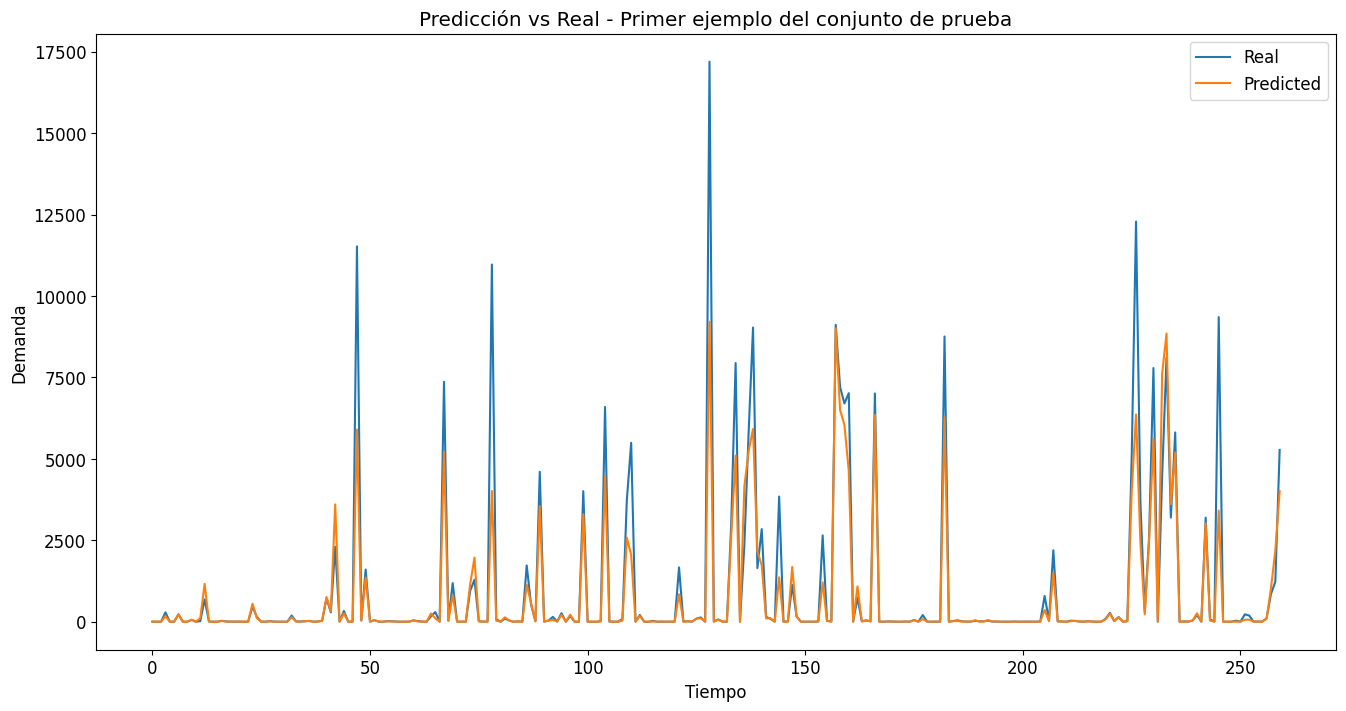

In [51]:
# Visualize some predictions vs. actual values
plt.figure(figsize=(16, 8))
plt.plot(y_test_inverse[0], label="Real")
plt.plot(y_pred_inverse[0], label="Predicted")
plt.legend()
plt.title("Predicción vs Real - Primer ejemplo del conjunto de prueba")
plt.xlabel("Tiempo")
plt.ylabel("Demanda")
plt.show()
